In [ ]:
def leer_dependencias(ruta_archivo_txt):
  dependencias = {}
  with open(ruta_archivo_txt, 'r') as f:
    for linea in f:
      linea = linea.strip()

      if not linea:
        continue

      partes = linea.split(':')
      servicio = partes[0].strip()
      dependencias[servicio] = []

      if len(partes) > 1 and partes[1].strip():
        dependencias_str = partes[1].strip().split(',')
        dependencias[servicio] = [dep.strip() for dep in dependencias_str]

    return dependencias


In [ ]:
def encontrar_ssc(grafo):
  visitado = set()
  stack = []
  scc = []

  def dfs1(servicio):
    visitado.add(servicio)
    if servicio in grafo:
      for vecino in grafo[servicio]:
        if vecino not in visitado:
          dfs1(vecino)

    stack.append(servicio)


  grafo_transpuesto = {}
  for servicio, deps in grafo.items():
      if servicio not in grafo_transpuesto:
          grafo_transpuesto[servicio] = []
      for dep in deps:
          if dep not in grafo_transpuesto:
              grafo_transpuesto[dep] = []
          grafo_transpuesto[dep].append(servicio)


  def dfs2(servicio, componente):
        visitado.add(servicio)
        componente.append(servicio)
        if servicio in grafo_transpuesto:
            for vecino in grafo_transpuesto[servicio]:
                if vecino not in visitado:
                    dfs2(vecino, componente)

  for servicio in grafo:
        if servicio not in visitado:
            dfs1(servicio)


  visitado = set()
  while stack:
      servicio = stack.pop()
      if servicio not in visitado:
          componente = []
          dfs2(servicio, componente)
          scc.append(componente)


  return scc

In [ ]:
# Creando el archivo TXT
with open('dependencias.txt', 'w') as f:
  f.write("UserService: DatabaseService, AuthService\n")
  f.write("LoggingService: DatabaseService, QueueService\n")
  f.write("DatabaseService:\n")
  f.write("QueueService: DatabaseService, MonitoringService\n")
  f.write("MonitoringService: LoggingService\n")
  f.write("PaymentService: UserService, QueueService\n")
  f.write("InventoryService: DatabaseService\n")
  f.write("RecommendationService: InventoryService, UserService\n")
  f.write("APIGateway: AuthService, UserService, PaymentService, InventoryService\n")

## Dibujando los grafos

(en esta parte se hizo uso de la IA Gemini)

In [ ]:
!pip install networkx matplotlib

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def dibujar_grafo_original(grafo):
    G = nx.DiGraph()

    todos_servicios = set(grafo.keys())
    for deps in grafo.values():
        todos_servicios.update(deps)

    for servicio in todos_servicios:
        G.add_node(servicio)


    for servicio, dependencias in grafo.items():
        for dep in dependencias:
            G.add_edge(servicio, dep)


    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, arrows=True)
    plt.title("Grafo de Dependencias Original")
    plt.show()

In [ ]:
def dibujar_grafo_scc(grafo, sccs):
    G_scc = nx.DiGraph()

    servicio_a_scc = {}
    for i, scc in enumerate(sccs):
        scc_nombre = f"SCC {i+1}: {', '.join(scc)}"
        G_scc.add_node(scc_nombre)
        for servicio in scc:
            servicio_a_scc[servicio] = scc_nombre

    for servicio, dependencias in grafo.items():
        scc_origen_nombre = servicio_a_scc.get(servicio)
        if scc_origen_nombre:
            for dep in dependencias:
                scc_destino_nombre = servicio_a_scc.get(dep)

                if scc_destino_nombre and scc_origen_nombre != scc_destino_nombre:
                    G_scc.add_edge(scc_origen_nombre, scc_destino_nombre)

    pos = nx.spring_layout(G_scc, seed=42)
    plt.figure(figsize=(15, 10))
    nx.draw(G_scc, pos, with_labels=True, node_size=4000, node_color='lightgreen', font_size=10, arrows=True, width=2)
    plt.title("Grafo Condensado (Componentes Fuertemente Conectados)")
    plt.show()

['APIGateway']
['RecommendationService']
['InventoryService']
['PaymentService']
['LoggingService', 'MonitoringService', 'QueueService']
['UserService']
['AuthService']
['DatabaseService']

====Dibujo de Grafos====


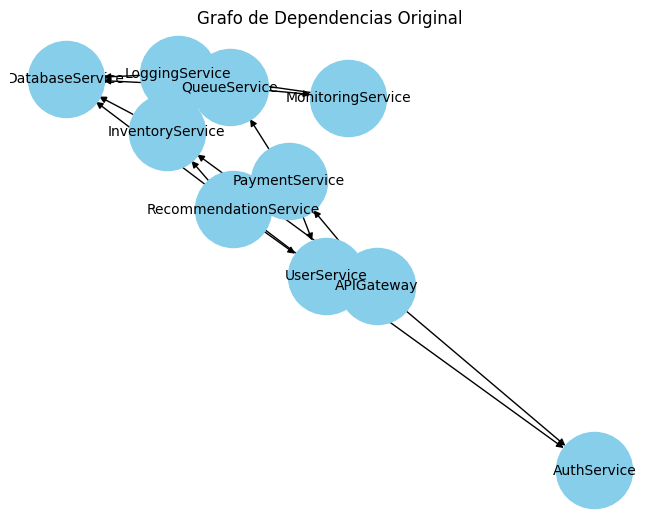

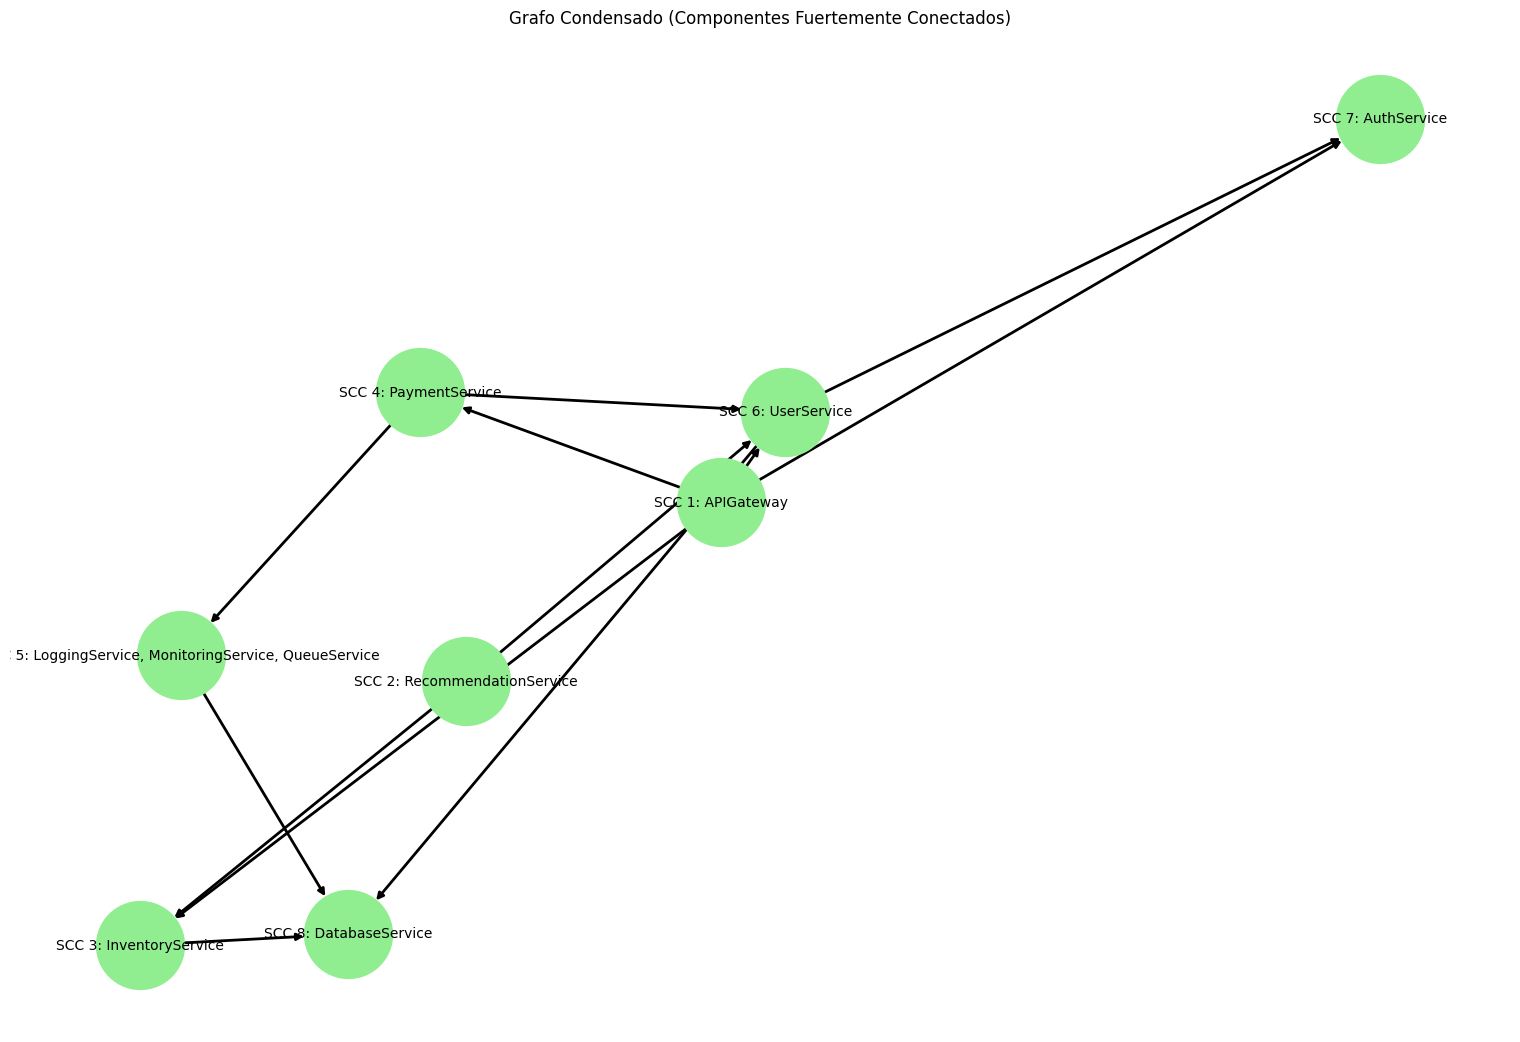

In [ ]:
def main():
  ruta_archivo = 'dependencias.txt'
  dependencias = leer_dependencias(ruta_archivo)
  microservicios_dependientes = encontrar_ssc(dependencias)

  for micro in microservicios_dependientes:
    print(micro)


  print("\n====Dibujo de Grafos====")
  dibujar_grafo_original(dependencias)
  dibujar_grafo_scc(dependencias, microservicios_dependientes)

if __name__ == '__main__':
  main()

## Sustentacion

Para este algoritmo se utilizo el algoritmo de Componentes Fuertemente Conectados. (SSC)

Porque?
Los SCCs son buenos para poder representar distintos grupos de elementos que tienen dependencias mutuas.


En el codigo escrito, se implementa el Algoritmo de Kosaraju. Este algoritmo tiene una complejidad temporal lineal con el numero de nodos y aristas del grafo.

1. Primer DFS: Se realiza una DFS en el grafo original. Durante el proceso de finalización de cada nodo en el DFS, los nodos se apilan en un orden específico.

2. Construcción del Grafo Transpuesto: Se construye un nuevo grafo invirtiendo la dirección de todas las aristas del grafo original.

3. Segundo DFS: Se realiza una segunda DFS en el grafo transpuesto, comenzando desde los nodos en el orden en que fueron apilados en la primera pasada. Cada árbol de DFS en esta segunda pasada representa un SCC del grafo original.